In [1]:
# Import ECG quality assessment functions
from ecg_quality import assess_ecg_quality

## ECG analysis (from analyze_ecg.py)

This notebook cell contains a port of the `ECG_analysis/analyze_ecg.py` script so you can run and inspect the results inline. It will load `ECG_analysis/mitbih_test.csv` if present, otherwise it runs a synthetic test signal.

CSV not found — running synthetic test signal
== ECG metrics ==
SDNN_s: 0.1098972560561973
RMSSD_s: 0.0756147643823122
mean_RR_s: 0.8287301587301587
mean_HR_bpm: 72.39992338632446
Detected beats: 36


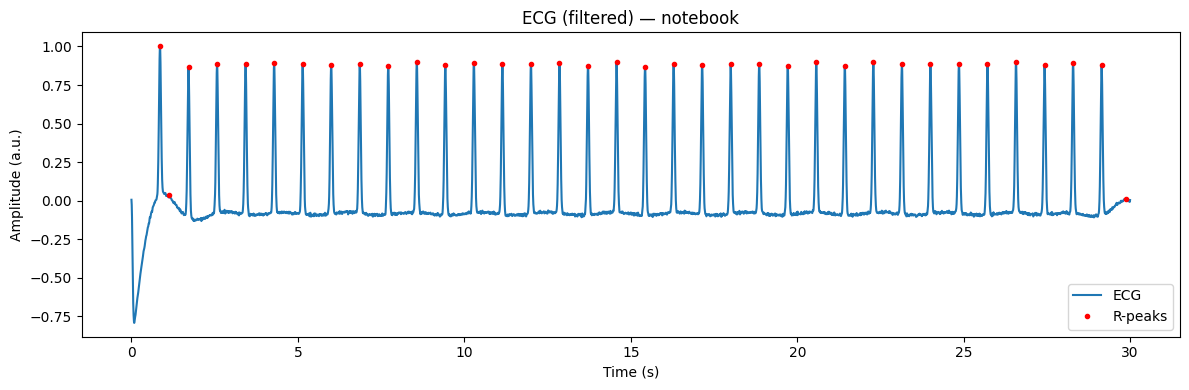

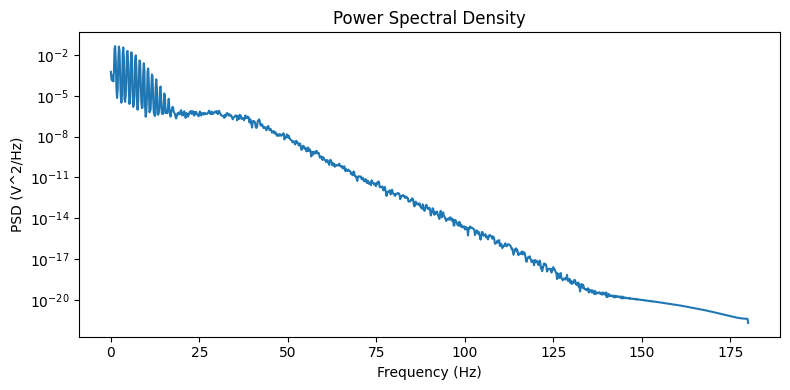

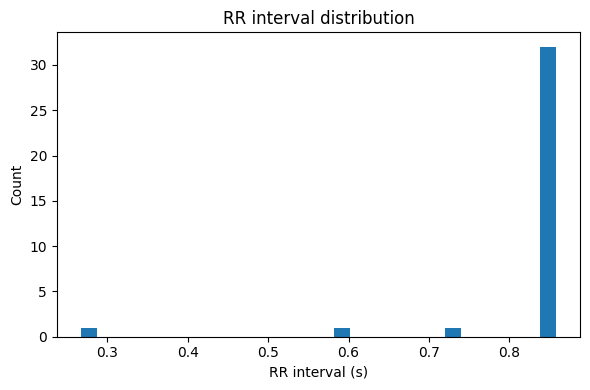

Notebook results saved to: /Users/mac/Documents/Tech_projects/ECG_analysis/ECG_results_notebook


In [2]:
%matplotlib inline

# Ported ECG analysis functions and runnable block
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks, welch
import matplotlib.pyplot as plt


def load_signal(path, column=None):
    """Load ECG signal from CSV using pandas.read_csv directly.

    Parameters
    - path: str or Path-like to CSV
    - column: None (first numeric) or int index or column name
    """
    df = pd.read_csv(path)
    if column is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise ValueError("No numeric column found in CSV")
        col = numeric_cols[0]
    else:
        if isinstance(column, int):
            col = df.select_dtypes(include=[np.number]).columns[column]
        else:
            col = column
    return df[col].astype(float).values


def synthesize_ecg(duration_s=10, fs=360, hr_bpm=60, noise_amp=0.01):
    t = np.arange(0, duration_s, 1.0 / fs)
    rr = 60.0 / hr_bpm
    beat_times = np.arange(0, duration_s, rr)
    sig = np.zeros_like(t)
    for bt in beat_times:
        sig += np.exp(-((t - bt) ** 2) / (2 * (0.03 ** 2)))
    sig += 0.02 * np.sin(2 * np.pi * 0.5 * t)
    sig += noise_amp * np.random.randn(len(t))
    sig = sig / np.max(np.abs(sig))
    return t, sig


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def bandpass_filter(sig, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, sig)
    return y


def detect_r_peaks(sig, fs, distance_s=0.25, height=None):
    distance_samples = int(distance_s * fs)
    peaks, props = find_peaks(sig, distance=distance_samples, height=height)
    return peaks, props


def compute_rr(peaks, fs):
    rr_samples = np.diff(peaks)
    rr_seconds = rr_samples / fs
    return rr_seconds


def hrv_metrics(rr_seconds):
    if len(rr_seconds) == 0:
        return {}
    sdnn = np.std(rr_seconds, ddof=1)
    rmssd = np.sqrt(np.mean(np.diff(rr_seconds) ** 2)) if len(rr_seconds) > 1 else np.nan
    mean_rr = np.mean(rr_seconds)
    mean_hr = 60.0 / mean_rr if mean_rr > 0 else np.nan
    return {"SDNN_s": sdnn, "RMSSD_s": rmssd, "mean_RR_s": mean_rr, "mean_HR_bpm": mean_hr}


def plot_signal(t, sig, peaks=None, fs=360, outpath=None, title="ECG Signal"):
    plt.figure(figsize=(12, 4))
    plt.plot(t, sig, label="ECG")
    if peaks is not None and len(peaks) > 0:
        plt.plot(t[peaks], sig[peaks], "r.", label="R-peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath)
        plt.close()
    else:
        plt.show()


def plot_psd(sig, fs, outpath=None):
    f, pxx = welch(sig, fs=fs, nperseg=min(2048, len(sig)))
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, pxx)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (V^2/Hz)")
    plt.title("Power Spectral Density")
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath)
        plt.close()
    else:
        plt.show()


# === Run analysis (editable parameters) ===
fs = 360
csv_path = "ECG_analysis/mitbih_test.csv"  # use a plain path string and pandas.read_csv inside load_signal
outdir = Path("ECG_results_notebook")
outdir.mkdir(parents=True, exist_ok=True)

# Try to load via pandas.read_csv; if missing, fall back to synthetic signal
try:
    sig = load_signal(csv_path, None)
    t = np.arange(0, len(sig)) / fs
except FileNotFoundError:
    print("CSV not found — running synthetic test signal")
    t, sig = synthesize_ecg(duration_s=30, fs=fs, hr_bpm=70)
except Exception as e:
    print(f"Error loading CSV (will run synthetic signal): {e}")
    t, sig = synthesize_ecg(duration_s=30, fs=fs, hr_bpm=70)

filtered = bandpass_filter(sig, 0.5, 40.0, fs=fs, order=4)

h = np.median(filtered) + 0.3 * np.std(filtered)
peaks, props = detect_r_peaks(filtered, fs=fs, distance_s=0.25, height=h)
rr_seconds = compute_rr(peaks, fs=fs)
metrics = hrv_metrics(rr_seconds)

print("== ECG metrics ==")
for k, v in metrics.items():
    print(f"{k}: {v}")
print(f"Detected beats: {len(peaks)}")

# Display plots inline
plot_signal(t, filtered, peaks=peaks, fs=fs, outpath=None, title="ECG (filtered) — notebook")
plot_psd(filtered, fs=fs, outpath=None)

# Save outputs to outdir
plot_signal(t, filtered, peaks=peaks, fs=fs, outpath=str(outdir / "ecg_signal.png"), title="ECG (filtered)")
plot_psd(filtered, fs=fs, outpath=str(outdir / "ecg_psd.png"))

# RR histogram
plt.figure(figsize=(6, 4))
if len(rr_seconds) > 0:
    plt.hist(rr_seconds, bins=30)
    plt.xlabel("RR interval (s)")
    plt.ylabel("Count")
    plt.title("RR interval distribution")
else:
    plt.text(0.5, 0.5, "No RR intervals found", ha="center")
plt.tight_layout()
plt.show()
plt.savefig(str(outdir / "rr_hist.png"))
plt.close()

# Summary CSV
summary = {
    "n_beats": len(peaks),
    "mean_hr_bpm": metrics.get("mean_HR_bpm", np.nan),
    "sdnn_s": metrics.get("SDNN_s", np.nan),
    "rmssd_s": metrics.get("RMSSD_s", np.nan),
}
import pandas as _pd
_pd.DataFrame([summary]).to_csv(outdir / "summary.csv", index=False)

print(f"Notebook results saved to: {outdir.resolve()}")


In [4]:
# Assess ECG signal quality after loading and filtering
quality_results = assess_ecg_quality(sig, fs)
print("== ECG Quality Assessment ==")
for k, v in quality_results.items():
    print(f"{k}: {v}")

== ECG Quality Assessment ==
noise_ok: True
noise_ratio: 0.0006363281528221509
baseline_wander_ok: True
wander_ratio: 0.0
clipping_ok: True
clipped_fraction: 0.00018518518518518518
lead_off_ok: True
variance: 0.05085196028428706
amplitude_ok: True
amplitude_range: (np.float64(-0.05155741694643643), np.float64(1.0))
missing_ok: True
missing: False
all_ok: True
